In [1]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(16,10)}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)

RandomState(MT19937) at 0x7FF7A1FDE140

In [2]:
lang_names_map = {'en': 'English', 'hi': 'Hindi', 'ko': 'Korean', 'fi': 'Finnish', 'es': 'Spanish'}
# model_name = 'xlm-roberta-base'
model_name = 'bert-base-multilingual-cased'

In [3]:
def get_indiv_df_for_plotting(df, push, template, other, random):
    '''
    Returns dataframe for one specific experiment condition
    '''
    
    if not random:
        col_name_1 = push + '_' + template + '_template_' + template + '_answer'
        col_name_2 = push + '_' + template + '_template_' + other + '_answer'
    else:
        col_name_1 = push + '_' + template + '_template_' + template + '_random_answer'
        col_name_2 = push + '_' + template + '_template_' + other + '_random_answer'

    baseline_1 = 'baseline_' + col_name_1[4:]
    answer_1 = df.loc[col_name_1].values[3:] - df.loc[baseline_1].values[3:]
    
    baseline_2 = 'baseline_' + col_name_2[4:]
    answer_2 = df.loc[col_name_2].values[3:] - df.loc[baseline_2].values[3:]
    
    logprob_values = np.concatenate((answer_1, answer_2))
    lang1 = template
    lang2 = other
    answer_values = [lang1 for i in range(len(answer_1))] + [lang2 for i in range(len(answer_2))]
    new_df = pd.DataFrame({'log_prob': logprob_values, 'answer': answer_values})
    
    return new_df


def get_df_for_plotting(filename: str, lang1: str, lang2: str):
    '''
        Returns combined dataframe for plotting
    '''
    df = pd.read_csv(filename)
    df['ind'] = df.apply(lambda x: str(x['model']) + '_' + str(x['template']) + '_' + str(x['answer']), axis=1)
    df.set_index('ind', inplace=True)
    
    df_push_1_templ_1 = get_indiv_df_for_plotting(df, push='neg', template=lang1, other=lang2, random=False)
    df_push_1_templ_2 = get_indiv_df_for_plotting(df, push='neg', template=lang2, other=lang1, random=False)
    df_push_2_templ_1 = get_indiv_df_for_plotting(df, push='pos', template=lang1, other=lang2, random=False)
    df_push_2_templ_2 = get_indiv_df_for_plotting(df, push='pos', template=lang2, other=lang1, random=False)
    
    df_push_1_templ_1_rand = get_indiv_df_for_plotting(df, push='neg', template=lang1, other=lang2, random=True)
    df_push_1_templ_2_rand = get_indiv_df_for_plotting(df, push='neg', template=lang2, other=lang1, random=True)
    df_push_2_templ_1_rand = get_indiv_df_for_plotting(df, push='pos', template=lang1, other=lang2, random=True)
    df_push_2_templ_2_rand = get_indiv_df_for_plotting(df, push='pos', template=lang2, other=lang1, random=True)
        
    push_1_templ_1_name = '==>' + lang_names_map[lang1] + '\n' + lang_names_map[lang1] + ' Template'
    push_1_templ_2_name = '==>' + lang_names_map[lang1] + '\n' + lang_names_map[lang2] + ' Template'
    push_2_templ_1_name = '==>' + lang_names_map[lang2] + '\n' + lang_names_map[lang1] + ' Template'
    push_2_templ_2_name = '==>' + lang_names_map[lang2] + '\n' + lang_names_map[lang2] + ' Template'
    

    combined_df = pd.concat({push_2_templ_1_name: df_push_2_templ_1, push_1_templ_1_name: df_push_1_templ_1, push_1_templ_2_name: df_push_1_templ_2, push_2_templ_2_name: df_push_2_templ_2})
    combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index(drop=True).loc[:, ['subplot', 'log_prob', 'answer']]
    combined_df['type'] = 'real'

    combined_df_rand = pd.concat({push_2_templ_1_name: df_push_2_templ_1_rand, push_1_templ_1_name: df_push_1_templ_1_rand, push_1_templ_2_name: df_push_1_templ_2_rand, push_2_templ_2_name: df_push_2_templ_2_rand})
    combined_df_rand = combined_df_rand.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index(drop=True).loc[:, ['subplot', 'log_prob', 'answer']]
    combined_df_rand['type'] = 'random'
    
    plot_df = pd.concat([combined_df, combined_df_rand]).reset_index(drop=True)
    
    g = sns.displot(kind='kde', data=plot_df, x='log_prob', hue='answer', fill=True, row='type', col='subplot', hue_order=[lang1, lang2])
    i = 0
    for row in g.axes:
        for ax, col_name in zip(row, g.col_names):
            if i<4:
                type_name = 'real'
            else:
                type_name = 'random'
            i+=1
            ax.axvline(x=plot_df[(plot_df['type']==type_name) & (plot_df['subplot']==col_name) & (plot_df['answer']==lang1)]['log_prob'].mean(), linewidth=1.5, color='b', alpha=0.5, linestyle='--')
            ax.axvline(x=plot_df[(plot_df['type']==type_name) & (plot_df['subplot']==col_name) & (plot_df['answer']==lang2)]['log_prob'].mean(), linewidth=1.5, color='r', alpha=0.5, linestyle='--')
            if type_name=='real':
                ax.set_title(col_name)
            else:
                ax.set_title('')
            ax.set_xlabel('')
            ax.set_ylabel('')
    
    g.tight_layout()

In [4]:
# get_df_for_plotting(filename='../svm-code/mixed/outputs/' + model_name + '/output_langs=en_hi_alpha=4.0_rand=False_control=False.csv', lang1='en', lang2='hi')

In [5]:
# get_df_for_plotting(filename='../svm-code/mixed/outputs/' + model_name + '/output_langs=en_ko_alpha=4.0_rand=False_control=False.csv', lang1='en', lang2='ko')

In [6]:
# get_df_for_plotting(filename='../svm-code/mixed/outputs/' + model_name + '/output_langs=hi_ko_alpha=4.0_rand=False_control=False.csv', lang1='hi', lang2='ko')

## True Random words

In [7]:
# get_df_for_plotting(filename='../svm-code/mixed/outputs/' + model_name + '/output_langs=en_hi_alpha=4.0_rand=True_control=False.csv', lang1='en', lang2='hi')

In [8]:
# get_df_for_plotting(filename='../svm-code/mixed/outputs/' + model_name + '/output_langs=en_ko_alpha=4.0_rand=True_control=False.csv', lang1='en', lang2='ko')

In [9]:
# get_df_for_plotting(filename='../svm-code/mixed/outputs/' + model_name + '/output_langs=hi_ko_alpha=4.0_rand=True_control=False.csv', lang1='hi', lang2='ko')

## Mono

In [10]:
def get_indiv_df(df, push, template, other):

    
    logprob_values_1 = df[df['template']==template]['logprob_true_' + push + '_norm'].values.tolist()
    logprob_values_2 = df[df['template']==template]['logprob_transl_' + push + '_norm'].values.tolist()
    answer_values = [template for i in range(len(logprob_values_1))] + [other for i in range(len(logprob_values_2))]
    
    new_df = pd.DataFrame({'log_prob': logprob_values_1 + logprob_values_2, 'answer': answer_values})
    
    return new_df

    

def get_df_for_plotting_mono(filename: str, lang1: str, lang2: str):
    '''
        Returns combined dataframe for plotting
    '''
    df = pd.read_csv(filename)
    
    df_rand = pd.read_csv(filename.replace('rand=False', 'rand=True'))
    
    df_push_1_templ_1 = get_indiv_df(df, push='neg', template=lang1, other=lang2)
    df_push_1_templ_2 = get_indiv_df(df, push='neg', template=lang2, other=lang1)
    df_push_2_templ_1 = get_indiv_df(df, push='pos', template=lang1, other=lang2)
    df_push_2_templ_2 = get_indiv_df(df, push='pos', template=lang2, other=lang1)
    
    push_1_templ_1_name = '==>' + lang_names_map[lang1] + '\n' + lang_names_map[lang1] + ' Template'
    push_1_templ_2_name = '==>' + lang_names_map[lang1] + '\n' + lang_names_map[lang2] + ' Template'
    push_2_templ_1_name = '==>' + lang_names_map[lang2] + '\n' + lang_names_map[lang1] + ' Template'
    push_2_templ_2_name = '==>' + lang_names_map[lang2] + '\n' + lang_names_map[lang2] + ' Template'
    
    df_push_1_templ_1_rand = get_indiv_df(df_rand, push='neg', template=lang1, other=lang2)
    df_push_1_templ_2_rand = get_indiv_df(df_rand, push='neg', template=lang2, other=lang1)
    df_push_2_templ_1_rand = get_indiv_df(df_rand, push='pos', template=lang1, other=lang2)
    df_push_2_templ_2_rand = get_indiv_df(df_rand, push='pos', template=lang2, other=lang1)

    combined_df = pd.concat({push_2_templ_1_name: df_push_2_templ_1, push_1_templ_1_name: df_push_1_templ_1, push_1_templ_2_name: df_push_1_templ_2, push_2_templ_2_name: df_push_2_templ_2})
    combined_df = combined_df.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index(drop=True).loc[:, ['subplot', 'log_prob', 'answer']]
    combined_df['type'] = 'real'
    
    combined_df_rand = pd.concat({push_2_templ_1_name: df_push_2_templ_1_rand, push_1_templ_1_name: df_push_1_templ_1_rand, push_1_templ_2_name: df_push_1_templ_2_rand, push_2_templ_2_name: df_push_2_templ_2_rand})
    combined_df_rand = combined_df_rand.reset_index(level=0).rename(columns={'level_0': 'subplot'}).reset_index(drop=True).loc[:, ['subplot', 'log_prob', 'answer']]
    combined_df_rand['type'] = 'random'
    
    plot_df = pd.concat([combined_df, combined_df_rand]).reset_index(drop=True)

    g = sns.displot(kind='kde', data=plot_df, x='log_prob', hue='answer', fill=True, col='subplot', row='type', hue_order=[lang1, lang2])
    
    
    i = 0
    for row in g.axes:
        for ax, col_name in zip(row, g.col_names):
            if i<4:
                type_name = 'real'
            else:
                type_name = 'random'
            i+=1
            ax.axvline(x=plot_df[(plot_df['type']==type_name) & (plot_df['subplot']==col_name) & (plot_df['answer']==lang1)]['log_prob'].mean(), linewidth=1.5, color='b', alpha=0.5, linestyle='--')
            ax.axvline(x=plot_df[(plot_df['type']==type_name) & (plot_df['subplot']==col_name) & (plot_df['answer']==lang2)]['log_prob'].mean(), linewidth=1.5, color='r', alpha=0.5, linestyle='--')
            if type_name=='real':
                ax.set_title(col_name)
            else:
                ax.set_title('')
            ax.set_xlabel('')
            ax.set_ylabel('')
    
    g.tight_layout()

In [11]:
# get_df_for_plotting_mono('../svm-code/mono/outputs/' + model_name + '/final_langs=en_hi_alpha=4.0_rand=False_control=False.csv', 'en', 'hi')

In [12]:
# get_df_for_plotting_mono('../svm-code/mono/outputs/' + model_name + '/final_langs=en_ko_alpha=4.0_rand=False_control=False.csv', 'en', 'ko')

In [13]:
# get_df_for_plotting_mono('../svm-code/mono/outputs/' + model_name + '/final_langs=en_es_alpha=4.0_rand=False_control=False.csv', 'en', 'es')

In [14]:
# get_df_for_plotting_mono('../svm-code/mono/outputs/' + model_name + '/final_langs=en_fi_alpha=4.0_rand=False_control=False.csv', 'en', 'fi')

## Plots for LM accuracy

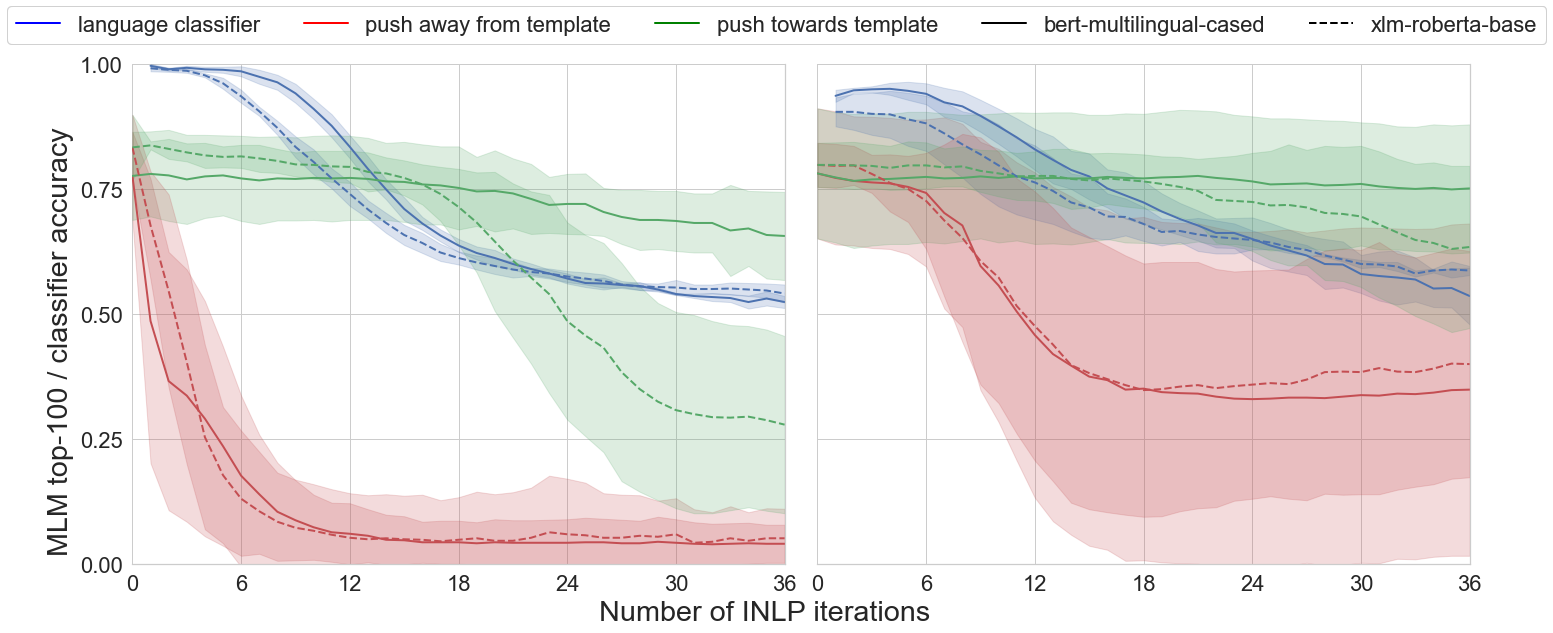

In [24]:
lmacc = pd.read_csv('lmacc.tsv', sep='\t')
lmacc_mixed = pd.read_csv('lmacc-mixed.tsv', sep='\t')

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,8),constrained_layout=True)
 
# Non codemixed plot
x = lmacc['iter']
mean_1 = lmacc['bert-inlp-avg'].values
mean_2 = lmacc['bert-pushawaytemp-avg'].values
mean_3 = lmacc['bert-pushtotemp-avg'].values

std_1 = lmacc['bert-inlp-std'].values
std_2 = lmacc['bert-pushawaytemp-std'].values
std_3 = lmacc['bert-pushtotemp-std'].values

mean_4 = lmacc['xlm-inlp-avg'].values
mean_5 = lmacc['xlm-pushawaytemp-avg'].values
mean_6 = lmacc['xlm-pushtotemp-avg'].values

std_4 = lmacc['xlm-inlp-std'].values
std_5 = lmacc['xlm-pushawaytemp-std'].values
std_6 = lmacc['xlm-pushtotemp-std'].values


# bert plots
ax[0].plot(x, mean_1, 'b-', linewidth=2)
ax[0].fill_between(x, mean_1 - std_1, mean_1 + std_1, color='b', alpha=0.2)
ax[0].plot(x, mean_2, 'r-', linewidth=2)
ax[0].fill_between(x, mean_2 - std_2, mean_2 + std_2, color='r', alpha=0.2)
ax[0].plot(x, mean_3, 'g-', linewidth=2)
ax[0].fill_between(x, mean_3 - std_3, mean_3 + std_3, color='g', alpha=0.2)


# roberta plots
ax[0].plot(x, mean_4, 'b--', linewidth=2)
ax[0].fill_between(x, mean_4 - std_4, mean_4 + std_4, color='b', alpha=0.2)
ax[0].plot(x, mean_5, 'r--', linewidth=2)
ax[0].fill_between(x, mean_5 - std_5, mean_5 + std_5, color='r', alpha=0.2)
ax[0].plot(x, mean_6, 'g--', linewidth=2)
ax[0].fill_between(x, mean_6 - std_6, mean_6 + std_6, color='g', alpha=0.2)

# Codemixed plot
x_mixed = lmacc_mixed['iter']
mean_1_mixed = lmacc_mixed['bert-inlp-avg'].values
mean_2_mixed = lmacc_mixed['bert-pushawaytemp-avg'].values
mean_3_mixed = lmacc_mixed['bert-pushtotemp-avg'].values

std_1_mixed = lmacc_mixed['bert-inlp-std'].values
std_2_mixed = lmacc_mixed['bert-pushawaytemp-std'].values
std_3_mixed = lmacc_mixed['bert-pushtotemp-std'].values

mean_4_mixed = lmacc_mixed['xlm-inlp-avg'].values
mean_5_mixed = lmacc_mixed['xlm-pushawaytemp-avg'].values
mean_6_mixed = lmacc_mixed['xlm-pushtotemp-avg'].values

std_4_mixed = lmacc_mixed['xlm-inlp-std'].values
std_5_mixed = lmacc_mixed['xlm-pushawaytemp-std'].values
std_6_mixed = lmacc_mixed['xlm-pushtotemp-std'].values

# bert plots
ax[1].plot(x_mixed, mean_1_mixed, 'b-', linewidth=2)
ax[1].fill_between(x_mixed, mean_1_mixed - std_1_mixed, mean_1_mixed + std_1_mixed, color='b', alpha=0.2)
ax[1].plot(x_mixed, mean_2_mixed, 'r-', linewidth=2)
ax[1].fill_between(x_mixed, mean_2_mixed - std_2_mixed, mean_2_mixed + std_2_mixed, color='r', alpha=0.2)
ax[1].plot(x_mixed, mean_3_mixed, 'g-', linewidth=2)
ax[1].fill_between(x_mixed, mean_3_mixed - std_3_mixed, mean_3_mixed + std_3_mixed, color='g', alpha=0.2)


# roberta plots
ax[1].plot(x_mixed, mean_4_mixed, 'b--', linewidth=2)
ax[1].fill_between(x_mixed, mean_4_mixed - std_4_mixed, mean_4_mixed + std_4_mixed, color='b', alpha=0.2)
ax[1].plot(x_mixed, mean_5_mixed, 'r--', linewidth=2)
ax[1].fill_between(x_mixed, mean_5_mixed - std_5_mixed, mean_5_mixed + std_5_mixed, color='r', alpha=0.2)
ax[1].plot(x_mixed, mean_6_mixed, 'g--', linewidth=2)
ax[1].fill_between(x_mixed, mean_6_mixed - std_6_mixed, mean_6_mixed + std_6_mixed, color='g', alpha=0.2)


# Common plotting elements

for i in range(2):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_xlim((0,36))
    ax[i].set_ylim((0,1))
    ax[i].set_xticks(np.arange(min(x_mixed), max(x_mixed)+1, 6.0))

ax[0].set_yticks(np.array([0, 0.25, 0.5, 0.75, 1.0]))

colors = ['blue', 'red', 'green']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in colors]
lines += [Line2D([0], [0], color='black', linewidth=2, linestyle='-'), Line2D([0], [0], color='black', linewidth=2, linestyle='--')]
labels = ['language classifier', 'push away from template', 'push towards template'] + ['bert-multilingual-cased', 'xlm-roberta-base']


color_legend = plt.legend(lines, labels, bbox_to_anchor = (0.05, 0.1, 1, 1), bbox_transform = plt.gcf().transFigure, frameon=True, ncol=5)
plt.gca().add_artist(color_legend)

fig.supxlabel('Number of INLP iterations')
fig.supylabel('MLM top-100 / classifier accuracy')

# plt.subplots_adjust(left=0.01)

plt.savefig('lmacc-iters.png', dpi=600, bbox_inches='tight')

In [18]:
lmacc.columns

Index(['iter', 'bert-inlp-avg', 'bert-inlp-std', 'bert-pushawaytemp—avg',
       'bert-pushawaytemp-std', 'bert-pushtotemp-avg',
       'bert-pushawaytemp-std.1', 'xlm-inlp-avg', 'xlm-inlp-std',
       'xlm-pushawaytemp-avg', 'xlm-pushawaytemp-std', 'xlm-pushtotemp-avg',
       'xlm-pushtotemp-std'],
      dtype='object')